Data file crypto_data.csv already exists. Skipping download.
Epoch [10/100], Loss: 0.0958
Epoch [20/100], Loss: 0.0712
Epoch [30/100], Loss: 0.0541
Epoch [40/100], Loss: 0.0318
Epoch [50/100], Loss: 0.0079
Epoch [60/100], Loss: 0.0038
Epoch [70/100], Loss: 0.0027
Epoch [80/100], Loss: 0.0017
Epoch [90/100], Loss: 0.0016
Epoch [100/100], Loss: 0.0015


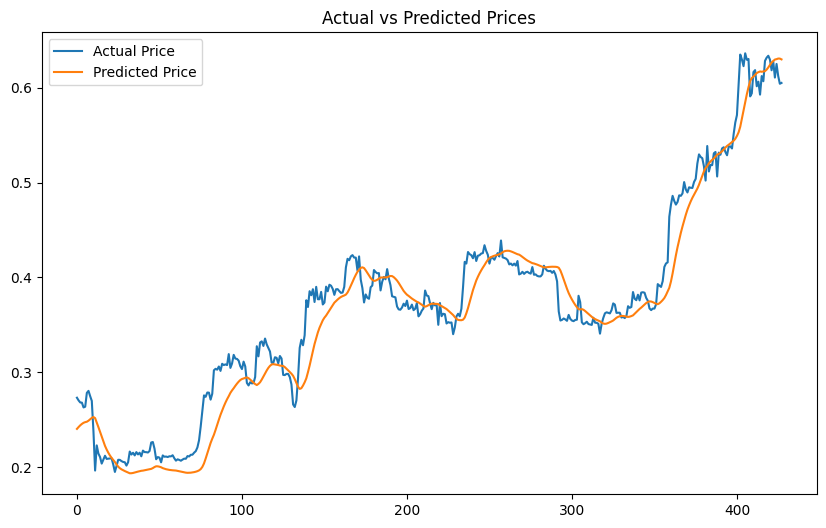

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import os
import yfinance as yf

# Define a function to download data if it doesn't exist
def download_crypto_data(symbol, start_date, end_date, file_name):
    if not os.path.exists(file_name):
        print(f"Downloading data for {symbol} from {start_date} to {end_date}...")
        data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
        data.to_csv(file_name)
        print(f"Data downloaded and saved to {file_name}")
    else:
        print(f"Data file {file_name} already exists. Skipping download.")

# Parameters for data acquisition
crypto_symbol = 'BTC-USD'
start_date = '2018-01-01'
end_date = '2023-12-31'
output_file = 'crypto_data.csv'

# Download data
download_crypto_data(crypto_symbol, start_date, end_date, output_file)

# Load the data
data = pd.read_csv(output_file)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize and train the model
input_size = X.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
predicted = model(X_test).detach().numpy()
actual = y_test.numpy()

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()


Data file crypto_data.csv already exists. Skipping download.
Epoch [10/100], Loss: 0.0707
Epoch [20/100], Loss: 0.0616
Epoch [30/100], Loss: 0.0406
Epoch [40/100], Loss: 0.0074
Epoch [50/100], Loss: 0.0034
Epoch [60/100], Loss: 0.0032
Epoch [70/100], Loss: 0.0026
Epoch [80/100], Loss: 0.0022
Epoch [90/100], Loss: 0.0021
Epoch [100/100], Loss: 0.0020


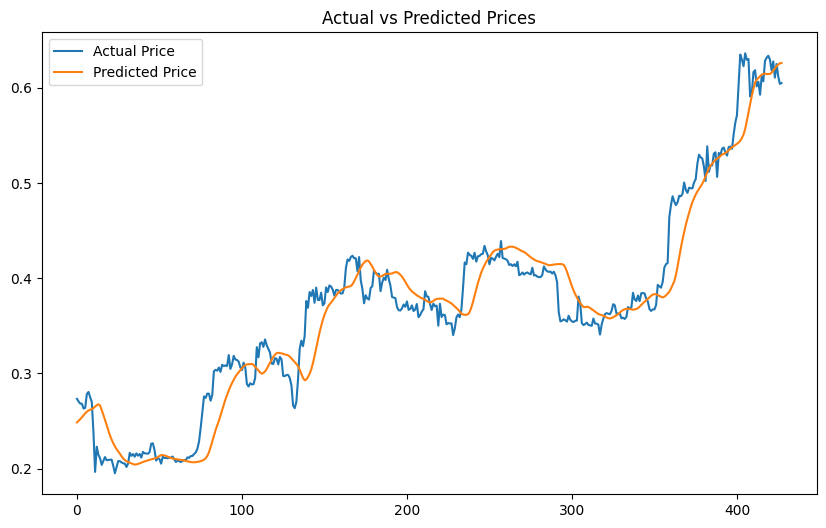

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import os
import yfinance as yf

# Define a function to download data if it doesn't exist
def download_crypto_data(symbol, start_date, end_date, file_name):
    if not os.path.exists(file_name):
        print(f"Downloading data for {symbol} from {start_date} to {end_date}...")
        data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
        data.to_csv(file_name)
        print(f"Data downloaded and saved to {file_name}")
    else:
        print(f"Data file {file_name} already exists. Skipping download.")

# Parameters for data acquisition
crypto_symbol = 'BTC-USD'
start_date = '2018-01-01'
end_date = '2023-12-31'
output_file = 'crypto_data.csv'

# Download data
download_crypto_data(crypto_symbol, start_date, end_date, output_file)

# Load the data
data = pd.read_csv(output_file)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Create sequences with shifted target
def create_sequences(data, seq_length, target_shift):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_shift):
        x = data[i:i + seq_length]
        y = data[i + seq_length + target_shift]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
target_shift = 3  # Predict 3 days ahead
X, y = create_sequences(scaled_data, seq_length, target_shift)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize and train the model
input_size = X.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
predicted = model(X_test).detach().numpy()
actual = y_test.numpy()

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()
